# Regression

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("car_prices_cleaned.csv")

encoding_maps = {}

categorical_columns = ["body", "transmission", "make"]
for column in categorical_columns:
    unique_values = data[column].dropna().unique()
    encoding_maps[column] = {value: idx for idx, value in enumerate(unique_values)}

for column in categorical_columns:
    encoded_column = f"{column}_encoded"
    data[encoded_column] = data[column].map(encoding_maps[column])

target = "sellingprice"
features = ["mmr", "odometer", "condition", "body_encoded", "transmission_encoded", "make_encoded"]

data = data.dropna(subset=features + [target])

X = data[features].values
y = data[target].values

def train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_index = int(X.shape[0] * (1 - test_size))
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

continuous_features = ["mmr", "odometer", "condition"]
continuous_indices = [features.index(f) for f in continuous_features]

def normalize_features(X, columns):
    means = np.mean(X[:, columns], axis=0)
    stds = np.std(X[:, columns], axis=0)
    X_normalized = X.copy()
    X_normalized[:, columns] = (X[:, columns] - means) / stds
    return X_normalized, means, stds

X_train_scaled, train_means, train_stds = normalize_features(X_train, continuous_indices)
X_test_scaled = X_test.copy()
X_test_scaled[:, continuous_indices] = (X_test[:, continuous_indices] - train_means) / train_stds

X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features)

print("Normalized Data - Training:")
print(X_train_scaled.head())
print("\nNormalized Data - Testing:")
print(X_test_scaled.head())


Normalized Data - Training:
        mmr  odometer  condition  body_encoded  transmission_encoded  \
0 -0.360160 -0.816813   0.406047           1.0                   0.0   
1 -0.344275 -0.382004   0.330444           1.0                   0.0   
2 -0.484592 -0.799528   0.481650           1.0                   0.0   
3  0.915929 -0.789887   0.481650           1.0                   0.0   
4 -1.305313  1.472600   0.784064           0.0                   0.0   

   make_encoded  
0           0.0  
1          16.0  
2          10.0  
3          14.0  
4          10.0  

Normalized Data - Testing:
        mmr  odometer  condition  body_encoded  transmission_encoded  \
0 -0.084821 -0.367696   0.859667          26.0                   0.0   
1  1.297168 -0.953459   1.313287           0.0                   0.0   
2 -0.879068  0.959279  -0.576797           0.0                   0.0   
3 -1.029975  0.560749   0.481650          26.0                   1.0   
4  0.375842 -0.065922   0.784064          5

In [2]:
X_train_scaled

,mmr,odometer,condition,body_encoded,transmission_encoded,make_encoded
0,-0.360160,-0.816813,0.406047,1.0,0.0,0.0
1,-0.344275,-0.382004,0.330444,1.0,0.0,16.0
2,-0.484592,-0.799528,0.481650,1.0,0.0,10.0
3,0.915929,-0.789887,0.481650,1.0,0.0,14.0
4,-1.305313,1.472600,0.784064,0.0,0.0,10.0
...,...,...,...,...,...,...
352309,-0.741398,0.309504,0.103633,5.0,0.0,17.0
352310,-1.149112,1.298599,-2.240071,26.0,0.0,21.0
352311,-1.109399,1.665671,0.330444,1.0,0.0,14.0
352312,0.074028,0.977562,-0.274383,0.0,0.0,31.0


NameError: name 'plt' is not defined

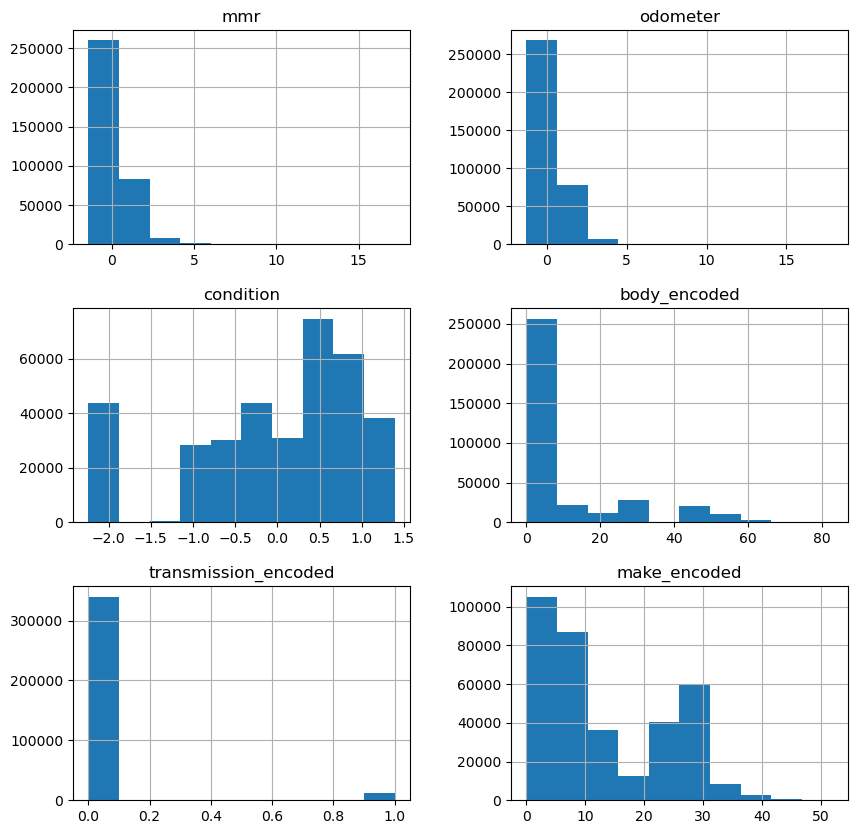

In [3]:
import matplotlib.pyplot as plt
X_train_scaled.hist(figsize=(10,10))
plt.plot()

# Cross validation and metrics
### Multiple Linear Regression with Ridge Regularization


In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold

class RidgeRegression:
    def __init__(self, learning_rate=0.001, lambda_=1.0, num_iterations=10000):
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = 0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)

        for _ in range(self.num_iterations):
            y_predicted = np.dot(X, self.weights) + self.bias
            residuals = y_predicted - y

            dw = (2 / n_samples) * (np.dot(X.T, residuals) + self.lambda_ * self.weights)
            db = (2 / n_samples) * np.sum(residuals)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

def cross_validate(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mse_list, mae_list, rmse_list, nrmse_list, r2_list = [], [], [], [], []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        nrmse = rmse / (y_test.max() - y_test.min())
        r2 = r2_score(y_test, y_pred)

        mse_list.append(mse)
        mae_list.append(mae)
        rmse_list.append(rmse)
        nrmse_list.append(nrmse)
        r2_list.append(r2)

    return {
        "MSE": np.mean(mse_list),
        "MAE": np.mean(mae_list),
        "RMSE": np.mean(rmse_list),
        "NRMSE": np.mean(nrmse_list),
        "R2": np.mean(r2_list)
    }

def parameter_search(X, y, learning_rates, lambdas, num_iterations_list, k=5):
    best_metrics = None
    best_params = None

    for lr in learning_rates:
        for lambda_ in lambdas:
            for num_iterations in num_iterations_list:
                print(f"Testing parameters: learning_rate={lr}, lambda_={lambda_}, num_iterations={num_iterations}")
                model = RidgeRegression(learning_rate=lr, lambda_=lambda_, num_iterations=num_iterations)

                try:
                    metrics = cross_validate(model, X, y, k=k)
                    print(f"Metrics: {metrics}")

                    if best_metrics is None or metrics["MSE"] < best_metrics["MSE"]:
                        best_metrics = metrics
                        best_params = {
                            "learning_rate": lr,
                            "lambda_": lambda_,
                            "num_iterations": num_iterations
                        }
                        print(f"New best parameters found: {best_params} with MSE={best_metrics['MSE']}")
                except Exception as e:
                    print(f"Skipping parameters due to error: {e}")
                    continue

    return best_params, best_metrics


# Define parameter ranges
learning_rates = [0.001, 0.01, 0.1]
lambdas = [0.1, 1.0, 10.0]
num_iterations_list = [1000, 5000, 10000]

# Run parameter search
best_params, best_metrics = parameter_search(X_train_scaled.values, y_train, learning_rates, lambdas, num_iterations_list, k=5)

Testing parameters: learning_rate=0.001, lambda_=0.1, num_iterations=1000
Metrics: {'MSE': 10569289.581701769, 'MAE': 2308.162094831586, 'RMSE': 3145.158846891323, 'NRMSE': 0.017830341692349625, 'R2': 0.8843931216052228}
New best parameters found: {'learning_rate': 0.001, 'lambda_': 0.1, 'num_iterations': 1000} with MSE=10569289.581701769
Testing parameters: learning_rate=0.001, lambda_=0.1, num_iterations=5000
Metrics: {'MSE': 2783634.110746582, 'MAE': 1049.9561660481818, 'RMSE': 1667.530868176355, 'NRMSE': 0.009339367172206707, 'R2': 0.969330516231883}
New best parameters found: {'learning_rate': 0.001, 'lambda_': 0.1, 'num_iterations': 5000} with MSE=2783634.110746582
Testing parameters: learning_rate=0.001, lambda_=0.1, num_iterations=10000
Metrics: {'MSE': 2762417.589809464, 'MAE': 1040.4152065739283, 'RMSE': 1661.0843506133308, 'NRMSE': 0.009301680136283868, 'R2': 0.9695600728437954}
New best parameters found: {'learning_rate': 0.001, 'lambda_': 0.1, 'num_iterations': 10000} with

In [5]:
best_params

{'learning_rate': 0.001, 'lambda_': 0.1, 'num_iterations': 10000}

## Std and intervals

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from scipy.stats import t

def cross_validate_with_stats(model, X, y, k=5, confidence=0.95):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mse_list, mae_list, rmse_list, nrmse_list, r2_list = [], [], [], [], []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)  
        nrmse = rmse / (y_test.max() - y_test.min())  
        r2 = r2_score(y_test, y_pred)

        mse_list.append(mse)
        mae_list.append(mae)
        rmse_list.append(rmse)
        nrmse_list.append(nrmse)
        r2_list.append(r2)

    metrics = {}
    for name, values in zip(["MSE", "MAE", "RMSE", "NRMSE", "R2"],
                            [mse_list, mae_list, rmse_list, nrmse_list, r2_list]):
        mean_val = np.mean(values)
        std_val = np.std(values, ddof=1)  
        n = len(values)
        t_critical = t.ppf((1 + confidence) / 2, df=n-1)  
        margin_of_error = t_critical * (std_val / np.sqrt(n))  
        confidence_interval = (mean_val - margin_of_error, mean_val + margin_of_error)

        metrics[name] = {
            "mean": mean_val,
            "std_dev": std_val,
            "conf_int": confidence_interval
        }

    return metrics

model = RidgeRegression(learning_rate=0.001, lambda_=0.1, num_iterations=10000)
metrics = cross_validate_with_stats(model, X_train_scaled.values, y_train, k=5)

for metric, stats in metrics.items():
    print(f"{metric}:")
    print(f"  Mean: {stats['mean']:.4f}")
    print(f"  Std Dev: {stats['std_dev']:.4f}")
    print(f"  95% Confidence Interval: ({stats['conf_int'][0]:.4f}, {stats['conf_int'][1]:.4f})")

MSE:
  Mean: 2762417.5898
  Std Dev: 213425.6573
  95% Confidence Interval: (2497414.6349, 3027420.5447)
MAE:
  Mean: 1040.4152
  Std Dev: 7.0767
  95% Confidence Interval: (1031.6284, 1049.2021)
RMSE:
  Mean: 1661.0844
  Std Dev: 63.4071
  95% Confidence Interval: (1582.3540, 1739.8147)
NRMSE:
  Mean: 0.0093
  Std Dev: 0.0010
  95% Confidence Interval: (0.0081, 0.0105)
R2:
  Mean: 0.9696
  Std Dev: 0.0023
  95% Confidence Interval: (0.9667, 0.9725)


In [6]:
best_params

{'learning_rate': 0.001, 'lambda_': 0.1, 'num_iterations': 10000}

# Shap

Exact explainer: 352315it [04:04, 1379.19it/s]                            



Importanța procentuală a caracteristicilor bazată pe valorile SHAP:
mmr                     93.268122
condition                5.373704
odometer                 0.504486
make_encoded             0.403447
body_encoded             0.350192
transmission_encoded     0.100049
dtype: float64


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


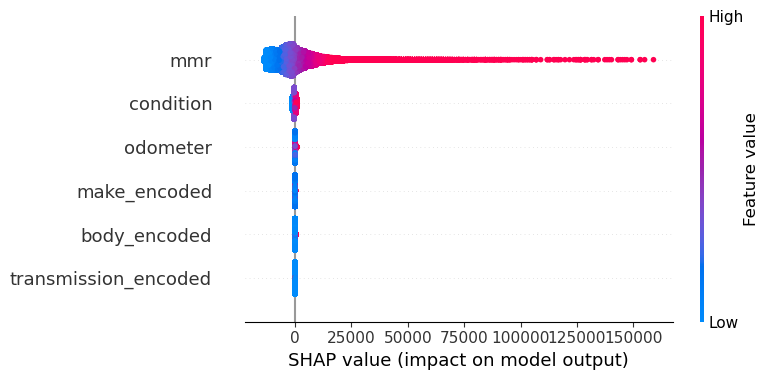

In [18]:
import shap
import pandas as pd

# Wrapper 
class RidgeWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

ridge_model = RidgeWrapper(model)
ridge_model.fit(X_train_scaled.values, y_train)

# SHAP explainer
explainer = shap.Explainer(ridge_model.predict, X_train_scaled.values)
shap_values = explainer(X_train_scaled.values)

shap_values_df = pd.DataFrame(
    shap_values.values,
    columns=X_train_scaled.columns
)

shap_feature_importance = shap_values_df.abs().mean()
shap_feature_importance_percent = (shap_feature_importance / shap_feature_importance.sum()) * 100
shap_feature_importance_percent = shap_feature_importance_percent.sort_values(ascending=False)

print("\nThe relative importance of features, expressed as a percentage, based on SHAP values:")
print(shap_feature_importance_percent)

shap.summary_plot(shap_values, X_train_scaled.values, feature_names=X_train_scaled.columns)


Exact explainer: 352315it [02:42, 2014.75it/s]                            



Importanța procentuală a caracteristicilor bazată pe valorile SHAP (fără mmr):
odometer                68.180510
condition               20.104793
body_encoded             8.722971
make_encoded             2.205412
transmission_encoded     0.786313
dtype: float64


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


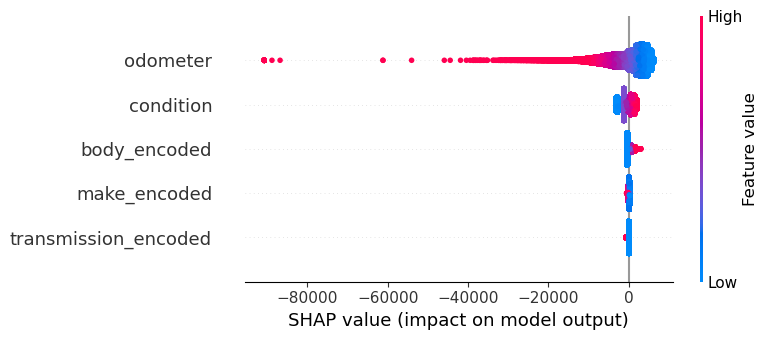

In [19]:
import shap
import pandas as pd

X_train_scaled_filtered = X_train_scaled.drop(columns=['mmr'])

ridge_model = RidgeWrapper(model)
ridge_model.fit(X_train_scaled_filtered.values, y_train)

explainer = shap.Explainer(ridge_model.predict, X_train_scaled_filtered.values)
shap_values = explainer(X_train_scaled_filtered.values)

shap_values_df = pd.DataFrame(
    shap_values.values,
    columns=X_train_scaled_filtered.columns
)

shap_feature_importance = shap_values_df.abs().mean()
shap_feature_importance_percent = (shap_feature_importance / shap_feature_importance.sum()) * 100

shap_feature_importance_percent = shap_feature_importance_percent.sort_values(ascending=False)

print("\nThe percentage importance of features based on SHAP values (without MMR).")
print(shap_feature_importance_percent)

shap.summary_plot(shap_values, X_train_scaled_filtered.values, feature_names=X_train_scaled_filtered.columns)


# Shap without mmr

Exact explainer: 352315it [02:55, 1880.98it/s]                            


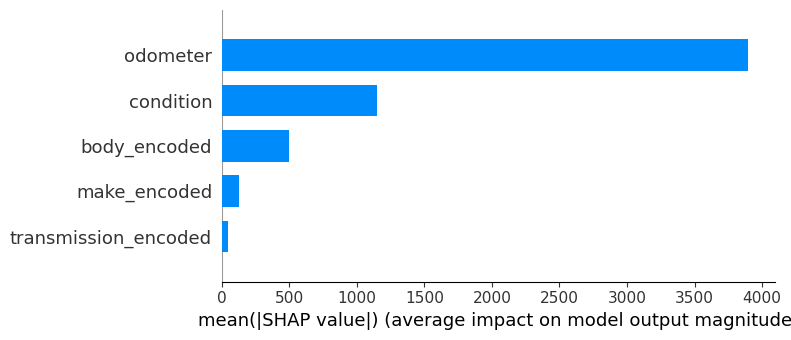

In [16]:
X_train_scaled_filtered = X_train_scaled.drop(columns=['mmr'])

ridge_model = RidgeWrapper(model)
ridge_model.fit(X_train_scaled_filtered.values, y_train)

explainer = shap.Explainer(ridge_model.predict, X_train_scaled_filtered.values)
shap_values = explainer(X_train_scaled_filtered.values)

shap.summary_plot(shap_values, X_train_scaled_filtered.values, feature_names=X_train_scaled_filtered.columns, plot_type="bar")


In [21]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ridge_model = Ridge(alpha=1, solver='auto', random_state=42)

ridge_model.fit(X_train_scaled.values, y_train)

y_pred = ridge_model.predict(X_test_scaled.values)

mse = mean_squared_error(y_test, y_pred) 
mae = mean_absolute_error(y_test, y_pred) 
rmse = np.sqrt(mse)  
nrmse = rmse / (y_test.max() - y_test.min())  
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE) on the test set: {mse:.4f}")
print(f"Mean Absolute Error (MAE) on the test set: {mae:.4f}")
print(f"Root Mean Squared Error (RMSE) on the test set: {rmse:.4f}")
print(f"Normalized RMSE (NRMSE) on the test set: {nrmse:.4f}")
print(f"R-squared (R²) on the test set: {r2:.4f}")

Mean Squared Error (MSE) pe setul de testare: 2757470.5175
Mean Absolute Error (MAE) pe setul de testare: 1047.7411
Root Mean Squared Error (RMSE) pe setul de testare: 1660.5633
Normalized RMSE (NRMSE) pe setul de testare: 0.0091
R-squared (R²) pe setul de testare: 0.9692
